In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot

In [2]:
sns.set_theme(context='notebook', style='whitegrid')
palname = 'vaporwave'
pal =  sns.blend_palette(vapeplot.palette(palname), n_colors=8)

In [3]:
snow_df = (pd.read_parquet('../../data/snow_data_clean.parquet', 
                         columns=['snowfall', 'region', 'pseudo_ts', 'station',
                                 'basecol_interpolated'])
           .query('basecol_interpolated==False & snowfall<=40')
           .drop(columns=['basecol_interpolated']))
snow_df.head()

,snowfall,region,pseudo_ts,station
11088,0.0,Other,1692-01-13,Mt. Holiday
11089,0.0,Other,1692-01-14,Mt. Holiday
11090,0.0,Other,1692-01-15,Mt. Holiday
11091,0.0,Other,1692-01-16,Mt. Holiday
11092,0.0,Other,1692-01-17,Mt. Holiday


In [4]:
snow_dist_df = (snow_df.groupby(['region'],)
                .agg(mean=('snowfall', 'mean'),
                     stdv=('snowfall', 'std'))
                .reset_index(['region'])
                .sort_values(['stdv'], ascending=False)
               )
snow_dist_df

,region,mean,stdv
6,Sierras,1.512045,4.450710
7,Utah,1.751008,3.708571
0,Cascades,1.624672,3.520222
1,Colorado,1.494006,3.027847
5,Rockies_Other,1.326346,2.861909
3,New_England,0.831223,2.446666
2,East,0.654089,2.080461
4,Other,0.524662,1.839717


In [9]:
station_counts = (snow_df.groupby(['region'])
                 .agg(stations_in_reg=('station', lambda x: 
                                            np.size(x.unique()))))
snow_freq_df = (snow_df.groupby(['region', 'snowfall'])
                .agg(snowfall_freq=('snowfall', 'count'))
                .reset_index()
                .merge(right=station_counts, how='left', on='region',
                       copy=True, indicator=False,)
                .assign(snowfall_freq=lambda x: x.snowfall_freq/x.stations_in_reg)
                .assign(ln_snowfall_freq=lambda x: np.log(x.snowfall_freq))
                .eval('total_snow=snowfall*snowfall_freq')
                .assign(total_snow_2grp=lambda x: 
                        x.total_snow.rolling(2, #win_type='triang', 
                                             min_periods=0).mean())
               )
# smoothed values are inaccurate on high curvature regions
snow_freq_df.loc[0:2, 'total_snow_2grp'] = snow_freq_df.loc[0:2,'total_snow']

This chart shows that the Sierras & Utah takes a much larger amount of their annual snowfall on single, large "Power Days". Colorado stations take much more of their snow in very frequent snowfalls of less than half a foot. It appears to follow a lognormal distribution, which I think is similar to plots of wind power generated annual at different speeds.

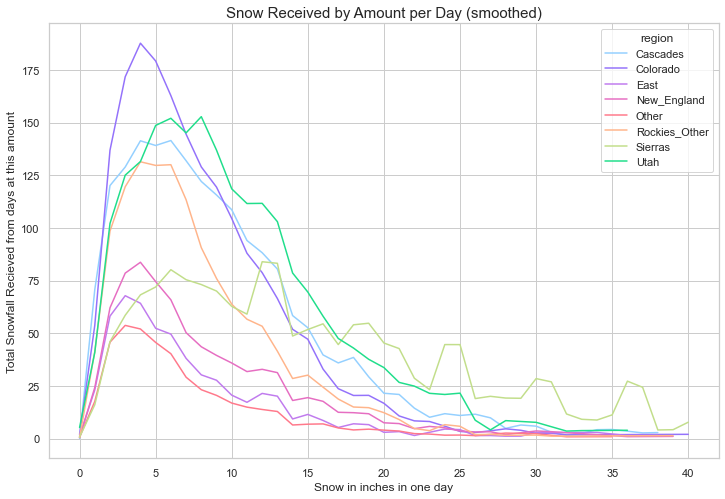

In [10]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.lineplot(data=snow_freq_df, x='snowfall', y='total_snow_2grp',
             hue='region', palette=pal)
ax.set_title('Snow Received by Amount per Day (smoothed)', size=15)
ax.set_xlabel('Snow in inches in one day')
ax.set_ylabel('Total Snowfall Recieved from days at this amount');

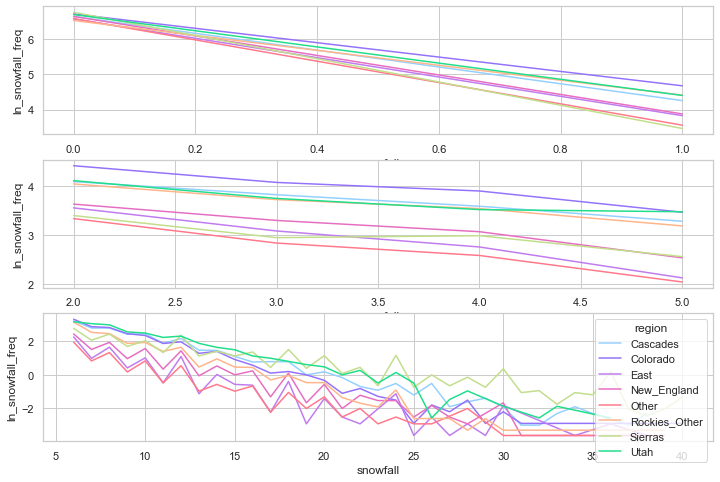

In [7]:
fig, ax = plt.subplots(3, figsize=(12,8))
def linesub(data, ax) -> None:
    sns.lineplot(data=data, ax=ax, x='snowfall', y='ln_snowfall_freq',
                hue='region', palette=pal)
linesub(snow_freq_df.query('snowfall<2'), ax=ax[0])
linesub(snow_freq_df.query('2<=snowfall<=5'), ax=ax[1])
linesub(snow_freq_df.query('snowfall>5'), ax=ax[2])
ax[0].legend().remove(), ax[1].legend().remove();

In [8]:
sns.lineplot(data=snow_freq_df.query('snowfall>2'), ax=ax[1],
            x="snowfall", y='ln_snowfall_freq', hue="region",
            palette=pal);